In [23]:
import jax.numpy as np
from jax import random, grad, jit
from jax.experimental import optimizers
from matplotlib import pyplot as plt
key = random.PRNGKey(0)

# Homework 2 - Part 1
## Neural network from scratch

The aim of this homework is to code all the operations of a fully connected neural network.

We will be using, for this part, a `python` library called `jax`. This library looks like `numpy`, but in the backend, it compiles the code "just in time" (`@jit`) into a more efficient code. Also, it has automatic differentiation in the function `grad`, which allows to do backpropagation to train the neural network.

Perhaps the major difference between `numpy` and `jax.numpy` is the way random numbers are generated. Here is an [`jax` example](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Common_Gotchas_in_JAX.ipynb) of how to generate a random vector with normally distributed values, with mean 0 and standard deviation 1.

In [24]:
key, subkey = random.split(key)
print(random.normal(subkey, shape = (5,1)))


[[-1.4581939]
 [-2.047044 ]
 [ 2.0473392]
 [ 1.1684095]
 [-0.9758364]]


We will use the same dataset as in homework 1:

In [25]:
!wget https://github.com/fsahli/PIML/raw/master/HW1/HW1data.npz

--2020-10-19 15:22:30--  https://github.com/fsahli/PIML/raw/master/HW1/HW1data.npz
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fsahli/PIML/master/HW1/HW1data.npz [following]
--2020-10-19 15:22:31--  https://raw.githubusercontent.com/fsahli/PIML/master/HW1/HW1data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1882 (1.8K) [application/octet-stream]
Saving to: ‘HW1data.npz.1’

HW1data.npz.1       100%[===================>]   1.84K  --.-KB/s    in 0s      

2020-10-19 15:22:31 (31.9 MB/s) - ‘HW1data.npz.1’ saved [1882/1882]



In [26]:
def f(x):
  return x*np.cos(x*np.pi)

data = np.load('HW1data.npz')
x_train = data['x_train'][:,None]
y_train = data['y_train'][:,None]
x_test = data['x_test'][:,None]
y_test = data['y_test'][:,None]

x_star = np.linspace(-1,1,100)[:,None]

## Problem 1
a) [10 points] Complete the function `init_params` to initialize the parameters of the neural network, according to the strategies we learned in class. Consider we will use a tanh non linearity. The number of layers and the number of neurons per layers is defined in the list `layers`. For example, the following network 

<a href="https://ibb.co/3ds91Rj"><img src="https://i.ibb.co/zx5Ts6B/Screen-Shot-2020-10-08-at-12-27-56-PM.png" alt="Screen-Shot-2020-10-08-at-12-27-56-PM" border="0"></a>

is defined with `layers = [1, 5, 5, 5, 1]`

b) [10 points] Complete the code in the function `forward_pass` that computes the forward pass of the neural net. All the hidden layers have tanh activations and the output layer should be linear.

#### Utilizaremos la regla de Glorot considerando parámetros que distribuyen normal. Como Jax solo permite generar parámetros que distribuyen N(0, 1), nos aprovecharemos de este hecho y utilizaremos la propiedad de distribución normal  tal que si c $\in \mathbb{R}$ e Y ~ $N(\mu, \sigma^2) \Rightarrow cY$ ~ $N(c \mu, c^2 \sigma ^2) $


In [27]:
layers = [1, 5, 5, 5, 1]


def init_params(layers, key):
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    n_in = layers[i]
    n_out = layers[i + 1]
    std_glorot = np.sqrt(2/(n_in + n_out))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, shape = (layers[i], layers[i+1])) * std_glorot)
    bs.append(np.zeros(layers[i + 1]))
  return [Ws, bs]

@jit
def forward_pass(H, params):
  N_layers = len(params[0])
  Ws = params[0]
  bs = params[1]
  for i in range(N_layers - 1):
    H = H.dot(Ws[i]) + bs[i]
    H = (2 / (1 + np.exp(-2 * H))) + 1
  Y = H.dot(Ws[-1]) + bs[-1]
  return Y

@jit
def loss(params, X, Y):
  return np.average((forward_pass(X, params) - Y)**2)



You can try if your code is working (or at least producing the right shape) with the following code:

In [28]:
params = init_params(layers, key)
y = forward_pass(x_train, params)
print(y.shape) # should be (30,1)

(30, 1)


## Problem 2
a) [2 points] Train the neural network using the function `train`. This functions uses the Adam optimizer to train the neural network.

b) [4 points] Complete the function `train_minibatch` to compute the gradient only with a subset of the dataset. The simplest way to do this is with the function `random.choice(subkey,...,..., replace = False)`. This will create a random set of indices that can be use to select elements in `X` and `Y` arrays. 

c) [4 points] Train the network with multiple `batch_size` and report what happens in terms of validation error. You can change the number of iterations `nIter`

In [32]:
params = init_params(layers, key)

opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(params)

@jit
def step(i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(X, Y, opt_state, X_val = None, Y_val = None, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step(it, opt_state, X, Y)            
        if it % 100 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %f" % (it, train_loss_value)
            if X_val is not None and Y_val is not None:
              val_loss_value = loss(params, X_val, Y_val)
              val_loss.append(val_loss_value)
              to_print += ", val loss = %f" % val_loss_value
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

def train_minibatch(X, Y, opt_state, key, X_val = None, Y_val = None, nIter = 10000, batch_size = 1):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        X_batch = random.choice(key, X.reshape(X.shape[0]), shape=(batch_size, 1), replace=False)
        Y_batch = random.choice(key, Y.reshape(Y.shape[0]), shape=(batch_size, 1), replace=False)
        opt_state = step(it, opt_state, X_batch, Y_batch)            
        if it % 100 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %f" % (it, train_loss_value)
            if X_val is not None and Y_val is not None:
              val_loss_value = loss(params, X_val, Y_val)
              val_loss.append(val_loss_value)
              to_print += ", val loss = %f" % val_loss_value
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

In [12]:
params, train_loss, val_loss = train(x_train, y_train, opt_state, X_val = x_test, Y_val = y_test)

it 0, train loss = 0.324974, val loss = 0.409780
it 100, train loss = 0.174356, val loss = 0.250722
it 200, train loss = 0.149016, val loss = 0.213342
it 300, train loss = 0.118875, val loss = 0.164013
it 400, train loss = 0.106619, val loss = 0.145436
it 500, train loss = 0.099526, val loss = 0.135197
it 600, train loss = 0.094547, val loss = 0.130044
it 700, train loss = 0.089581, val loss = 0.126492
it 800, train loss = 0.085252, val loss = 0.124527
it 900, train loss = 0.082444, val loss = 0.124426
it 1000, train loss = 0.080587, val loss = 0.124594
it 1100, train loss = 0.078652, val loss = 0.123725
it 1200, train loss = 0.073573, val loss = 0.119406
it 1300, train loss = 0.059241, val loss = 0.105868
it 1400, train loss = 0.040050, val loss = 0.086985
it 1500, train loss = 0.027174, val loss = 0.069003
it 1600, train loss = 0.021172, val loss = 0.057346
it 1700, train loss = 0.019013, val loss = 0.053134
it 1800, train loss = 0.017948, val loss = 0.051506
it 1900, train loss = 0.

validation MSE: 0.06817658


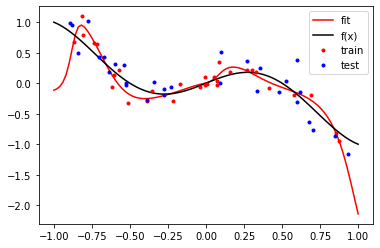

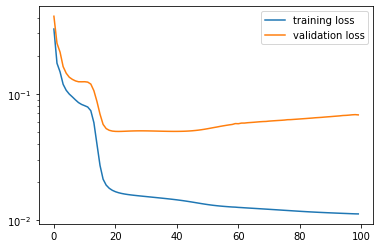

In [13]:
y_star = forward_pass(x_star, params)

plt.plot(x_star, y_star, 'r', label = 'fit')
plt.plot(x_star, f(x_star), 'k', label = 'f(x)')
plt.plot(x_train, y_train, 'r.', label = 'train')
plt.plot(x_test, y_test, 'b.', label = 'test')
plt.legend()

plt.figure()
plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label = 'validation loss')
plt.yscale('log')
plt.legend()

print('validation MSE:', val_loss[-1])

In [33]:
batch_size = 2
params, train_loss, val_loss = train_minibatch(x_train, y_train, opt_state, key, X_val = x_test, Y_val = y_test, batch_size = batch_size, nIter = 20000)


it 0, train loss = 0.324974, val loss = 0.409780
it 100, train loss = 0.195455, val loss = 0.278253
it 200, train loss = 0.178903, val loss = 0.256401
it 300, train loss = 0.171545, val loss = 0.246418
it 400, train loss = 0.165844, val loss = 0.236236
it 500, train loss = 0.155561, val loss = 0.220694
it 600, train loss = 0.143687, val loss = 0.204074
it 700, train loss = 0.136079, val loss = 0.190765
it 800, train loss = 0.135954, val loss = 0.189223
it 900, train loss = 0.125724, val loss = 0.175003
it 1000, train loss = 0.119803, val loss = 0.165361
it 1100, train loss = 0.117871, val loss = 0.163836
it 1200, train loss = 0.116070, val loss = 0.161213
it 1300, train loss = 0.114581, val loss = 0.158407
it 1400, train loss = 0.111515, val loss = 0.152401
it 1500, train loss = 0.110084, val loss = 0.149801
it 1600, train loss = 0.112137, val loss = 0.149419
it 1700, train loss = 0.107961, val loss = 0.147284
it 1800, train loss = 0.106833, val loss = 0.146542
it 1900, train loss = 0.

batch size: 2
validation MSE: 0.050717954


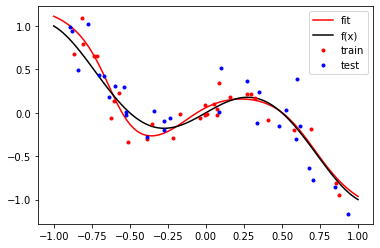

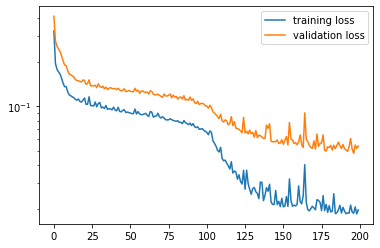

In [34]:
y_star = forward_pass(x_star, params)

plt.plot(x_star, y_star, 'r', label = 'fit')
plt.plot(x_star, f(x_star), 'k', label = 'f(x)')
plt.plot(x_train, y_train, 'r.', label = 'train')
plt.plot(x_test, y_test, 'b.', label = 'test')
plt.legend()

plt.figure()
plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label = 'validation loss')
plt.yscale('log')
plt.legend()

print('batch size:', batch_size)
print('validation MSE:', loss(params, x_test, y_test))